**IMDb**（Internet Movie Datebase ）是全球最大的互联网影视数据库，而[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 是一个根据IMDB上电影评论而建立的数据集。它由斯坦福大学于 2011 年发布。

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf

from collections import Counter
from scipy import stats
from sklearn.feature_extraction import text
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

base_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code'
sys.path.append(base_path)

from text_classification import set_gpu_memory, lr_schedule, ngram_vectorize, sequence_vectorize
from text_classification import plot_distribution, plot_length_distribution, plot_frequency_distribution
from text_classification import DictToObject, TextClassificationHelper
from text_classification import SimpleTextDataset, SequenceTextDataset

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

设置GPU最大内存。

In [3]:
set_gpu_memory(1024)
model_results={}

set max gpu memory to 1024


初始化参数。

In [4]:
params = {
    'dataset_name': 'imdb',
    'sample_perecent': 0.5,    
    'classes': ['Negative', 'Positive'],
    'validation_percent': 0.0,     
    'batch_size': 32,    
    'max_features': 5000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'restore_best_checkpoint':True,
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':20},
        'rnn':{'dropout':0.3, 'embedding_dim':200, 'units':200, 'epochs':5},
        'sepcnn':{'dropout':0.3, 'epochs': 20},
    }
}

params = DictToObject(params)

### 下载数据

开始下载数据。

In [5]:
dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/aclImdb') 
if not os.path.exists(dataset_dir):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True)

print(dataset_dir)

/root/.keras/datasets/aclImdb


![image-20201217095446441](images/image-20201217095446441.png)

下面是压缩文件解开后的目录结构。

![image-20201104115404253](images/image-20201104115404253.png)

其中train和test目录包含了实际的文本数据，详细说明见[IMDB](https://eipi10.cn/others/2020/10/22/dataset/#imdb---large-movie-review-dataset)。

### 查看数据

下面看一看实际的数据是啥样的。

In [6]:
def get_files(base_dir):
    pos_dir = os.path.join(base_dir, 'pos')
    pos_files = os.listdir(pos_dir)
    pos_files = [os.path.join(pos_dir, file_name) for file_name in pos_files]
    
    neg_dir = os.path.join(base_dir, 'neg')
    neg_files = os.listdir(neg_dir)
    neg_files = [os.path.join(neg_dir, file_name) for file_name in neg_files]    

    return pos_files, neg_files

train_pos_files, train_neg_files = get_files(os.path.join(dataset_dir, 'train'))
test_pos_files, test_files = get_files(os.path.join(dataset_dir, 'test'))
    
print('train dataset: {} positive reviews, {} negative reviews'.format(len(train_pos_files), len(train_neg_files)))
print('test dataset: {} positive reviews, {} negative reviews'.format(len(test_pos_files), len(test_files)))

train dataset: 12500 positive reviews, 12500 negative reviews
test dataset: 12500 positive reviews, 12500 negative reviews


![image-20201217115036617](images/image-20201217115036617.png)

首先看一看正面的评论。

In [7]:
for file_path in train_pos_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...') 

------------------------------/root/.keras/datasets/aclImdb/train/pos/127_7.txt------------------------------
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.
------------------------------/root/.keras/datasets/aclImdb/train/pos/126_10.txt------------------------------
Zentropa is the most original movie I've seen in y

![image-20201217111649607](images/image-20201217111649607.png)

然后看一看负面的评论。

In [8]:
for file_path in train_neg_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...')

------------------------------/root/.keras/datasets/aclImdb/train/neg/127_4.txt------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher ...
------------------------------/root/.keras/datasets/aclImdb/train/neg/126_1.txt------

![image-20201217100213645](images/image-20201217100213645.png)

## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [9]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_imdb_sentiment_analysis_dataset(imdb_data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(dataset_dir)

if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=12500, train_labels.shape=(12500,)
test_texts.length=12500, test_labels.shape=(12500,)


![image-20201217122349480](images/image-20201217122349480.png)

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

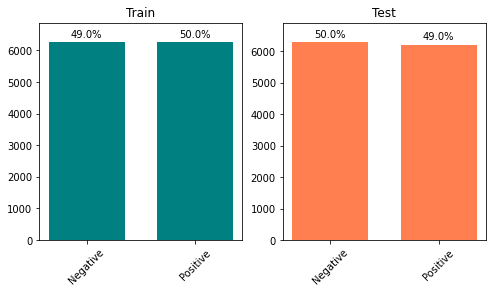

In [10]:
plot_distribution(train_labels, test_labels, params.classes)

![image-20201217123826241](images/image-20201217123826241.png)

### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

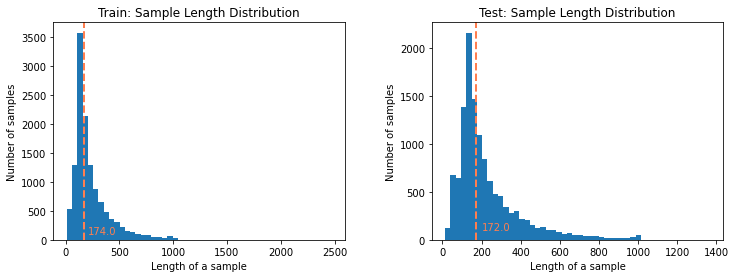

train：mean=233.99 variance=31095.97
test：mean=229.06 variance=28200.55


In [11]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))

![image-20210101163434402](images/image-20210101163434402.png)

通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [12]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,1547,5851,2314,1185,638,398,223,137,207,12500
train,1492,5837,2290,1188,679,384,230,159,241,12500
合计,3039,11688,4604,2373,1317,782,453,296,448,25000


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,1519.5,5844.0,2302.0,1186.5,658.5,391.0,226.5,148.0,224.0,12500.0
train,1519.5,5844.0,2302.0,1186.5,658.5,391.0,226.5,148.0,224.0,12500.0
合计,3039.0,11688.0,4604.0,2373.0,1317.0,782.0,453.0,296.0,448.0,25000.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [13]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 6.991748985985265
critical_value = 15.50731305586545
p_value = 0.5375231541283897


![image-20210101174317709](images/image-20210101174317709.png)

### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

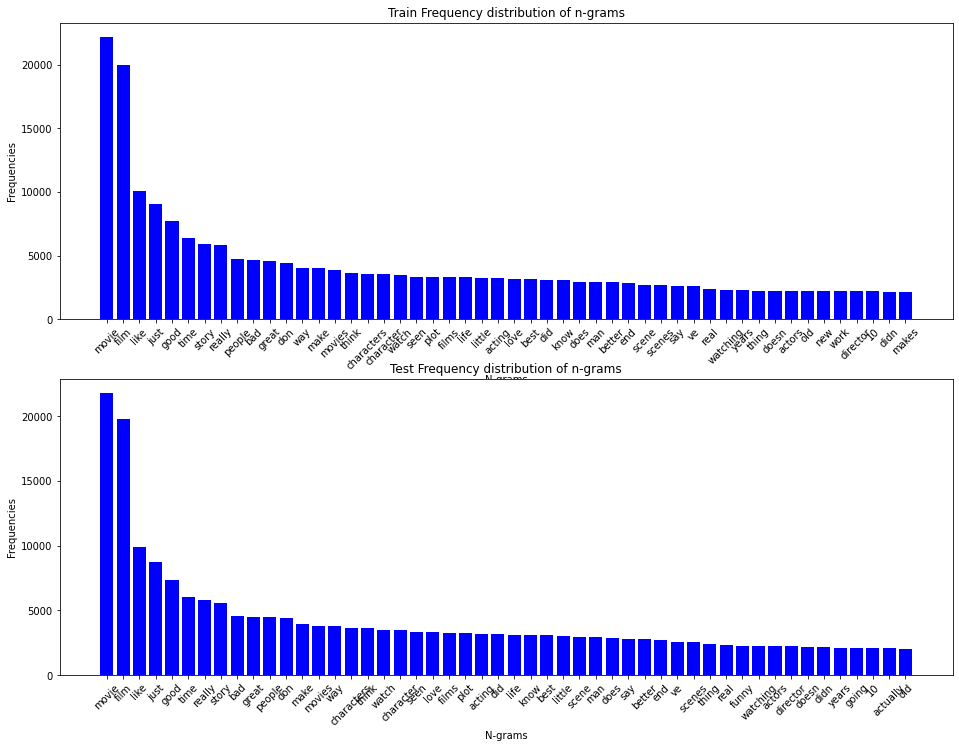

In [14]:
plot_frequency_distribution(train_texts, test_texts)

![image-20201217134151280](images/image-20201217134151280.png)

In [15]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 283708
Number of Vocabulary: 13713


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [16]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 71.8


![image-20201217144321430](images/image-20201217144321430.png)

可以看到这个比例大大小于143.7，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下两个过程。

- Tokenization：把文本转化成Token
- Vectorization： 把Token变成Vector

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [17]:
train_ngram, test_ngram, token_vectorizer = ngram_vectorize(train_texts, train_labels, test_texts, 
                                                            top_k=params.max_features)

print(train_ngram.shape, type(train_ngram), train_ngram.dtype)
print(test_ngram.shape, type(test_ngram), test_ngram.dtype)
print(train_ngram[0, 0:1000])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


(12500, 5000) <class 'scipy.sparse.csr.csr_matrix'> float32
(12500, 5000) <class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 20)	0.02128568
  (0, 96)	0.03164001
  (0, 100)	0.026494531
  (0, 106)	0.019379586
  (0, 129)	0.019426879
  (0, 158)	0.08752921
  (0, 252)	0.011190698
  (0, 259)	0.042901777
  (0, 295)	0.057157498
  (0, 345)	0.026987782
  (0, 398)	0.018768707
  (0, 510)	0.03553721
  (0, 628)	0.027148496
  (0, 653)	0.034523476
  (0, 657)	0.104724005
  (0, 664)	0.05236668
  (0, 707)	0.03120559
  (0, 733)	0.022543633
  (0, 766)	0.022104984
  (0, 872)	0.11462066
  (0, 898)	0.0402904
  (0, 899)	0.04119549
  (0, 900)	0.038361326
  (0, 907)	0.03318913
  (0, 913)	0.013663313
  (0, 916)	0.02105689
  (0, 922)	0.022112424


![image-20210102091446193](images/image-20210102091446193.png)

可以看到上面数据是以稀疏矩阵的形式存在的。下面创建ngram数据集。

In [18]:
ngram_data = SimpleTextDataset(params, train_ngram, train_labels, test_ngram, test_labels, train_texts, test_texts)

create train, validation and test dataset


### Sequence

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。下面将采用两种方式生成Sequence向量。

- Tokenizer
- TextVectorization

#### Tokenizer

In [23]:
train_seq, test_seq, tokenizer_seq = sequence_vectorize(train_texts, test_texts, 
                                                        top_k=params.max_features,
                                                        max_sequence_length =params.sequence_length
                                                       )

print(train_seq.shape, type(train_seq), train_seq.dtype)
print(test_seq.shape, type(test_seq), test_seq.dtype)
print(test_seq[0][0:500])

(2500, 500) <class 'numpy.ndarray'> int32
(2500, 500) <class 'numpy.ndarray'> int32
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

![image-20210102105418015](images/image-20210102105418015.png)

创建sequence数据集。

In [24]:
sequence_data = SequenceTextDataset(params, train_seq, train_labels, test_seq, test_labels, 
                                    train_texts, test_texts, tokenizer_seq)

create train, validation and test dataset


#### TextVectorization

下面直接从原始的文件读入数据，删除无用的目录。

In [26]:
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))
remove_dir = os.path.join(train_dir, 'unsup')
if os.path.exists(remove_dir): shutil.rmtree(remove_dir)
print(os.listdir(train_dir))

['neg', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']
['neg', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


![image-20210102102355896](images/image-20210102102355896.png)

把数据下载进dataset。

In [27]:
batch_size = params.batch_size
validation_split = params.validation_percent
seed = 42

if validation_split>0:
    raw_train_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size, 
        validation_split=validation_split,
        subset='training', 
        seed=seed)

    print('-'*100)
    raw_val_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size, 
        validation_split=validation_split,
        subset='validation', 
        seed=seed)    
    
else:
    print('-'*100)
    raw_train_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size)
    raw_val_seq_ds = None


print('-'*100)
raw_test_seq_ds = preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'), 
    batch_size=batch_size)

for text_batch, label_batch in raw_train_seq_ds.take(1):
    for i in range(3):
        print('-'*50, label_batch.numpy()[i], '-'*50)
        print(text_batch.numpy()[i])
        
print('-'*100)
print("Label 0 corresponds to", raw_train_seq_ds.class_names[0])
print("Label 1 corresponds to", raw_train_seq_ds.class_names[1])       

----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
-------------------------------------------------- 0 --------------------------------------------------
b'Don\'t bother. A little prosciutto could go a long way, but all we get is pure ham, particularly from Dunaway. The plot is one of those bumper car episodes... the vehicle bounces into another and everything changes direction again, until we are merely scratching our heads wondering if there were ever a plot. Gina Phillips is actually good, but it\'s hard playing across from a mystified Dunaway playing Lady Macbeth lost in the Marx\'s Brother\'s Duck Soup. Ah, the Raven...now there\'s an actor. And there is the relative who just lies and bed and looks ghostly. Or Dr. Dread who\'s filled with lots of gl

![image-20210102102702043](images/image-20210102102702043.png)

然后把进行Vectorization。

In [28]:
max_features = params.max_features
sequence_length = params.sequence_length

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_seq_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

print("7 ---> ",vectorize_layer.get_vocabulary()[7])
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

7 --->  is
1287 --->  lovely
 313 --->  idea
Vocabulary size: 20000


![image-20210102105650161](images/image-20210102105650161.png)

然后生成具体的train，validation，test数据集。

In [29]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_seq_ds = raw_train_seq_ds.map(vectorize_text)
if raw_val_seq_ds is not None:
    val_seq_ds = raw_val_seq_ds.map(vectorize_text)
else:
    val_seq_ds = None
test_seq_ds = raw_test_seq_ds.map(vectorize_text)

# cache data to improve the performance
train_seq_ds = train_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
if val_seq_ds is not None: 
    val_seq_ds = val_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_seq_ds = test_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 查看数据
vector_batch, label_batch = next(iter(train_seq_ds))
first_vector, first_label = vector_batch[0], label_batch[0]

print('Label：{}'.format(params.classes[first_label]))
print('-'*40, 'Vector', '-'*40)
print(first_vector.numpy())
print('-'*40, 'orginal review', '-'*40)
print(' '.join([vectorize_layer.get_vocabulary()[v] for v in first_vector]))

Label：Negative
---------------------------------------- Vector ----------------------------------------
[    5   257    10    13   145     1    10   437     1    10   409   785
   288   785   443    13   592     3   437     2   464    28 12925    47
     7     4 10485   119    10   152   118    42    11    30    31    28
     5    55   339   569    69    42    11    10    13    62  2146    10
   285     2    85   443   643    48     4   408     5  1875  1591   245
   469  5058    47     7    57  1111  1292    73   953    99    30     2
   126     5   168   379    71    68  1248     4  3058     5     4 15316
   174    31    36  2208    11   116    34  1150    12     2   364   262
  2388   305    76    26  4922   488  3311   351  1764  1891   653 15108
 16710     3    46    50     9     7    40   609    12    47     7   156
    45    47    30     2   548     6   103  4854  2192     1   125     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  

![image-20210102141537073](images/image-20210102141537073.png)

![image-20210102141609143](images/image-20210102141609143.png)

##  模型

### MLP

In [30]:
def sparse_to_dense(value):
    if isinstance(value, tf.sparse.SparseTensor):
        return tf.sparse.to_dense(value)
    return value

def get_mlp(helper, dropout=None, name='mlp'):
    """Creates an instance of a multi-layer perceptron model"""
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    layer_count = helper.get_model_param(name, 'layer_count')
    units = helper.get_model_param(name, 'units')    
    
    input = layers.Input(shape=helper.data.input_shape)    
    x = tf.keras.layers.Lambda(sparse_to_dense)(input)
    if dropout>0: x = layers.Dropout(dropout)(x)
        
    for _ in range(layer_count):
        x = layers.Dense(units, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    
    model = Model(inputs=input, outputs=x, name=name)     
    helper.compile(model)   
    return model

helper = TextClassificationHelper(params, model_results=model_results, data=ngram_data)
model = get_mlp(helper)
model.summary()

model_params.mlp.dropout=0.6
model_params.mlp.layer_count=1
model_params.mlp.units=256
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/mlp/checkpoint
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 20000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5120256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)

2021-01-04 08:54:44,076: INFO: start training


model_params.mlp.epochs=20
use ModelCheckpoint(filepath=./checkpoints/imdb/mlp/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/20
79/79 [==============================] - 1s 10ms/step - loss: 0.6331 - accuracy: 0.7536 - val_loss: 0.5458 - val_accuracy: 0.8220
Epoch 2/20
79/79 [==============================] - 1s 7ms/step - loss: 0.3474 - accuracy: 0.9172 - val_loss: 0.3859 - val_accuracy: 0.8348
Epoch 3/20
79/79 [==============================] - 1s 7ms/step - loss: 0.1679 - accuracy: 0.9612 - val_loss: 0.3432 - val_accuracy: 0.8488
Epoch 4/20
79/79 [==============================] - 1s 7ms/step - loss: 0.1039 - accuracy: 0.9760 - val_loss: 0.3301 - val_accuracy: 0.8600
Epoch 5/20
79/79 [==============================] - 0s 6ms/step - loss: 0.0702 - accuracy: 0.9860 - val_loss: 0.3284 - val_accuracy: 0.8568
Epoch 6/20
79/79 [======

2021-01-04 08:54:55,343: INFO: finish training [elapsed time: 11.27 seconds]


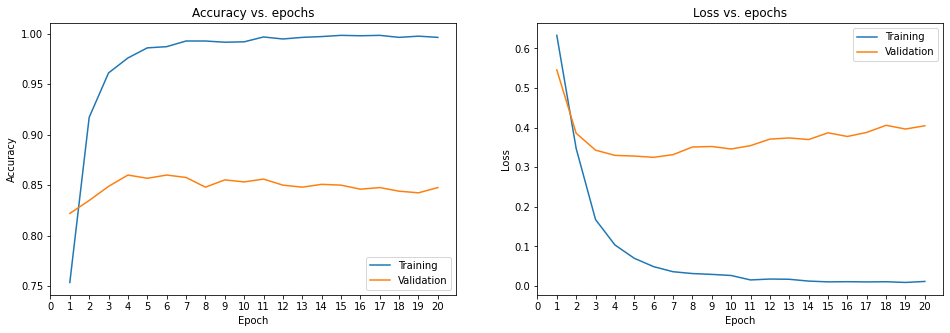

In [31]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
79/79 [==============================] - 0s 2ms/step - loss: 0.3301 - accuracy: 0.8600
Test loss:0.3301, Test Accuracy:86.00%
---------------------------------------- confusion matrix ----------------------------------------
79/79 [==============================] - 0s 2ms/step


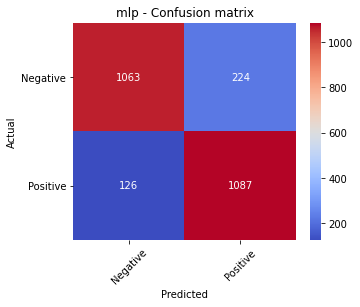

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.041012,0.9968,0.330073,0.86,5120770,11.0


In [32]:
helper.model_summary(model, history=history)

### RNN

In [35]:
def get_rnn(helper, name='rnn', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')    
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.SimpleRNN(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_rnn(helper)
model.summary()

model_params.rnn.dropout=0.3
model_params.rnn.units=200
max_features=20000
model_params.rnn.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn/checkpoint
Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 200)               80200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 4,080,802
Trainable params: 4,080,802
Non-trainable params: 0
_____

2021-01-04 08:55:45,736: INFO: start training


model_params.rnn.epochs=5
use ModelCheckpoint(filepath=./checkpoints/imdb/rnn/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
78/78 [==============================] - 33s 421ms/step - loss: 0.7514 - accuracy: 0.5044 - val_loss: 0.6995 - val_accuracy: 0.5164
Epoch 2/5
78/78 [==============================] - 32s 417ms/step - loss: 0.7544 - accuracy: 0.5296 - val_loss: 0.6898 - val_accuracy: 0.5264
Epoch 3/5
78/78 [==============================] - 33s 418ms/step - loss: 0.7160 - accuracy: 0.5621 - val_loss: 0.6966 - val_accuracy: 0.5324
Epoch 4/5
78/78 [==============================] - 32s 415ms/step - loss: 0.6449 - accuracy: 0.6242 - val_loss: 0.6705 - val_accuracy: 0.5604
Epoch 5/5
78/78 [==============================] - 32s 415ms/step - loss: 0.5410 - accuracy: 0.7228 - val_loss: 0.7117 - val_accuracy: 0.5644


2021-01-04 08:58:31,982: INFO: finish training [elapsed time: 166.25 seconds]


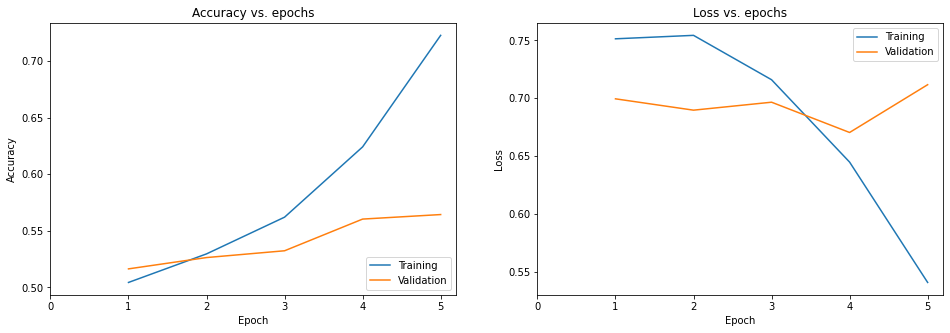

In [36]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
79/79 [==============================] - 6s 71ms/step - loss: 0.7117 - accuracy: 0.5644
Test loss:0.7117, Test Accuracy:56.44%
---------------------------------------- confusion matrix ----------------------------------------
79/79 [==============================] - 6s 70ms/step


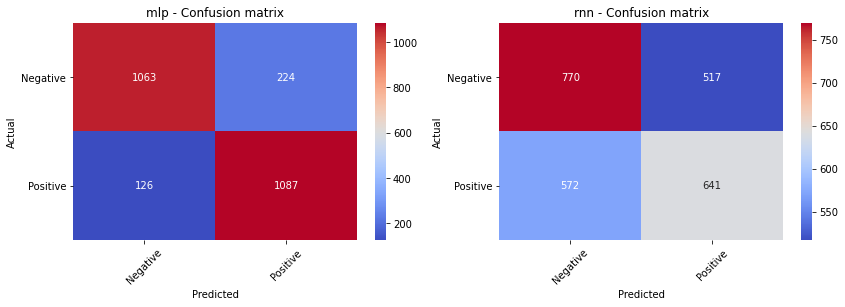

---------------------------------------- error analysis ----------------------------------------
79/79 [==============================] - 6s 71ms/step
........................................ Positive ........................................
I can understand how Barney can be annoying to some, but the hatred he gets is very ridiculous. Barney was made simply right from the beginning and simplicity isn't bad, especially for the young ones he entertains. I personally find this show to be very underrated period. Barney & Friends is a very educational show in my opinion and even 17 years after its debut (and nearly 21 years after the character's debut on home video), he proves time and time again that he still appeals to young children. Maybe less so than in the early 90's where Barney was the Hannah Montana of the time, but he's still a classic. As a fan of Barney myself, I feel that I should defend him in a way that doesn't seem like spam. The way the purple guy teaches things may be ver

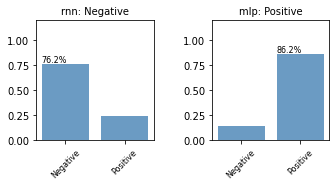

........................................ Negative ........................................
The filmmaker stayed true to the most accurate account of the story published in 1894 which includes an 1846 manuscript by Richard Williams Bell (son of John and Lucy Bell and younger brother of Betsy Bell) titled "Our Family Trouble." To knowledge this is the only eyewitness account ever penned. The filmmaker should be credited for accuracy but there is little to say about the production and acting quality. The acting was theatrical and the sound and picture quality was extremely poor. It appears that the filmmaker simply shot scenes of the reported events that took place without incorporating or weaving them into a flowing plot or story line. If you must know the story, read about it, its much more gripping and conclusive.


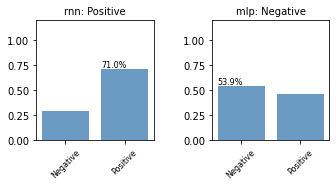

........................................ Positive ........................................
This event defined an era of wrestling entertainment that, I believe, is not equaled today. The colorful characters - in their stereotypical garb - brought a certain charm to the show that has since been raped by society and overexposed. Wrestling had a bit of an innocence back then. A kid could watch it without watching an episode of Jerry Springer.<br /><br />Looking back now (I was 5 at the time), although I loved both Warrior and Hogan, I think I enjoyed Warrior more because of his mystique. Hogan was the branded hero who weilded an impressive public image. The Ultimate Warrior, on the other hand, was a masked man of few words - an out-of-the-limelight hero for a different audience.<br /><br />This rivalry was so exciting as a kid because of this duality in me duking it out for each combatant. I had a place for both of them. Because there was bloodshed too in this long, heavy battle, the stak

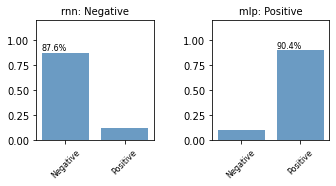

........................................ Negative ........................................
this movie is allegedly a comedy.so where did all the laughs go.did the forget to put them in,on the version i watched.as a football movie,it is mildly entertaining,i guess.maybe'm just a stick in the mud,with no discernible sense of humour.or maybe this movie just isn't funny.it is also annoying,with that way over the top "you're a winner"musical score.and the odd thing is,the team sucked through most of the season,only winning the last two games,and the last game meant nothing since they were not in the playoffs.so what is the point? are they celebrating mediocrity?I don't see it.if anybody knows,please let me know.anyway,this movie isn't great or even very good.i'm giving it a low 3*


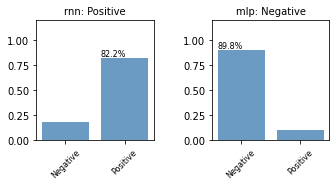

........................................ Positive ........................................
Greetings again from the darkness. Director Alejandro Amenabar creates life against all odds in this based on a true story version of one man's struggle to control his destiny. The great Javier Bardem is fascinating to watch in his role as Ramon. His eyes and head movements leave little doubt what is going on in his mind. The dream and fantasy sequences are not overused so prove very effective in explaining why he wants what he wants. Rather than force us to answer the euthanasia question, the real question posed is , What is Love? At every turn we see people in love, looking for love or dying to be loved. The script is tight and keeps the film moving despite being filmed mostly in one room. The supporting cast is wonderful and we truly feel their pain and how each family member deals with Ramon's decision. This is a gem and deserves to be seen.


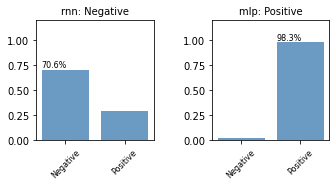

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.041012,0.9968,0.330073,0.8600,5120770,11.0
rnn,0.429040,0.8085,0.711746,0.5644,4080802,166.0


In [37]:
helper.model_summary(model, history=history)

### LSTM

In [38]:
def get_lstm(helper, name='rnn_lstm', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   

    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm(helper)
model.summary()


model_params.rnn_lstm.dropout=0.3
model_params.rnn_lstm.units=200
max_features=20000
model_params.rnn_lstm.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn_lstm/checkpoint
Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 402       
Total params: 4,321,402
Trainable params: 4,321,402
Non-

2021-01-04 08:58:58,998: INFO: start training


model_params.rnn_lstm.epochs=5
use ModelCheckpoint(filepath=./checkpoints/imdb/rnn_lstm/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
78/78 [==============================] - 51s 656ms/step - loss: 0.6730 - accuracy: 0.5885 - val_loss: 0.6082 - val_accuracy: 0.7052
Epoch 2/5
78/78 [==============================] - 50s 641ms/step - loss: 0.3759 - accuracy: 0.8510 - val_loss: 0.5215 - val_accuracy: 0.7716
Epoch 3/5
78/78 [==============================] - 50s 642ms/step - loss: 0.1020 - accuracy: 0.9667 - val_loss: 0.7079 - val_accuracy: 0.7876
Epoch 4/5
78/78 [==============================] - 50s 641ms/step - loss: 0.0316 - accuracy: 0.9920 - val_loss: 0.6896 - val_accuracy: 0.7300
Epoch 5/5
78/78 [==============================] - 50s 643ms/step - loss: 0.0212 - accuracy: 0.9932 - val_loss: 0.8075 - val_accuracy: 0.7856


2021-01-04 09:03:16,174: INFO: finish training [elapsed time: 257.18 seconds]


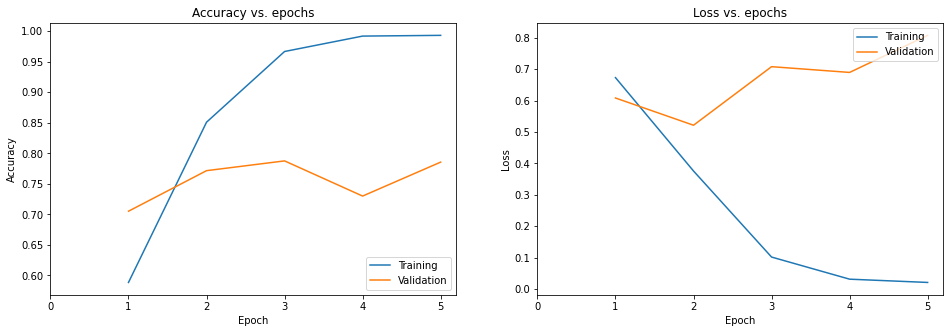

In [39]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
79/79 [==============================] - 9s 118ms/step - loss: 0.7079 - accuracy: 0.7876
Test loss:0.7079, Test Accuracy:78.76%
---------------------------------------- confusion matrix ----------------------------------------
79/79 [==============================] - 9s 118ms/step


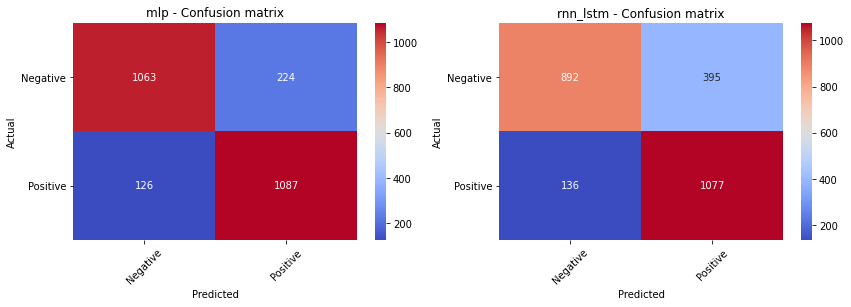

---------------------------------------- error analysis ----------------------------------------
79/79 [==============================] - 9s 117ms/step
........................................ Negative ........................................
This movie is stupid, made by stupid people. The plot I suppose works well enough for a Horror movie, but the actions these characters take is insanely STUPID! Like, incredibly non-sensical stupid to the Nth degree! Basically the whole movie consists of these 4 idiots being captured, repeatedly, despite having many, many easy ways and opportunities to overcome their captor. It does not make one lick of sense and is not entertaining whatsoever. Stabbing yourself in the eye is more is more rational, and probably more fun than watching this.<br /><br />****SPOILERS**** The ending is hilarious!! The only good part of the movie! I nearly died laughing at the end! That whole stupid movie, and it ends with the dumb girl getting shipped off in a crate to 

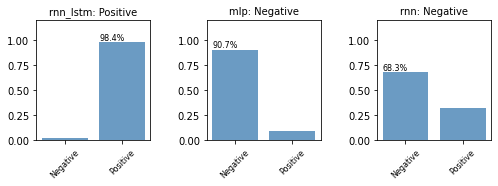

........................................ Negative ........................................
I rarely give ratings less than 5, but in this instance I must weigh in. Elmore Leonard is a great writer with many wonderful, complex books, original characters, crisp dialogue, invigorating plot twists. Films based on his books go way back to Hombre (Paul Newman), Mr. Majestyk (Bronson), and Out of Sight (Clooney / Lopez) among others. Even when done so-so the films at least have some measure of story essence coming through. This one, .... it is simply not a worthy addition to the catalog.<br /><br />The acting is bad (I do not know why, because these are very capable people here) and the story is handled with stupidity. The characters are re-arranged, the chemistry is missing, the actors and actresses are mis-cast.<br /><br />Since Elmore Leonard is a really great story teller, I would hope that anyone who does not know his work would be dissuaded from reading his books because they saw this d

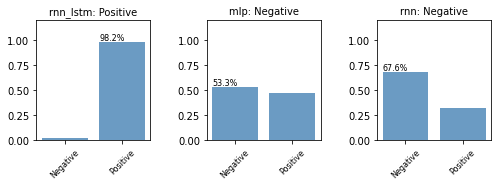

........................................ Negative ........................................
Imagine an exploitive remake of The Defiant Ones with a black chick and a white chick attached to each other. Set the story on some Caribbean island where the drug dealers rule and the revolution has arrived. And have the black woman be from Huggy Bear's stable of ladies and the white woman be a watered down Patty Hearst and you've got Black Mama, White Mama.<br /><br />In those waning days of the drive-in theater this item must have been a big old hit. All the hot buttons of the Seventies are pushed in this one. Even though they both fill out their clothes better and will get a few whistles from the males in the audience no one is ever going to mistake Pam Grier and Margaret Markov for Sidney Poitier and Tony Curtis. All right, Halle Berry and Jamie Lee Curtis.<br /><br />Margaret and Pam are prisoners where the guards and the warden look lasciviously at the new fish arriving. Margaret is a rich

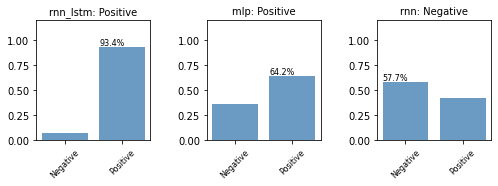

........................................ Negative ........................................
A fine line up of actors and a seemingly nice plot -- though not original -- promised me a nice evening in front of the TV. I was disappointed. The actors delivered up to standard (Juliette Lewis cuddly as ever; William Hurt solid but in the background; Shelley Duvall convincing as ever) but the story was too thin to keep me engaged to the story and, the twist to the finale was too obvious and too late; there was only one character who was nice to he girl, so guess what?! Then the final after-twist I do not know what to think of that. The boyfriend and the neighbor? Contract with the Devil, or just to get her to move in? What! The film had a nice idea behind it, but the idea was not worked out in detail. It could have been good, but it was not. Too many loose ends to tie up, Columbo would say.


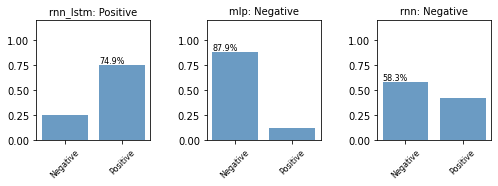

........................................ Negative ........................................
What a waste of talent -- although it appears that Crudup in real life is a lot more like the vapid, self- absorbed, character-less character he portrays in this disappointing movie.<br /><br />In art, sometimes the empty spaces reveal more than the painted or created content. What this movie reveals is the unconsciousness and the contradictory/competing, unresolved impulses/consciousness of the film's director/writer. It unintentionally shows the LACK of awareness that a truly evolved, deeply aware character should have and be tormented about in order to deserve audience empathy or sympathy OR the lack of which is used to serve as a cautionary tale to the audience. But this film fails on either level in that regard.<br /><br />The fact that Cal, the main character (very much an ANTagonist, not a protagonist in the true sense of the word), has no empathy for anyone, especially those most deservin

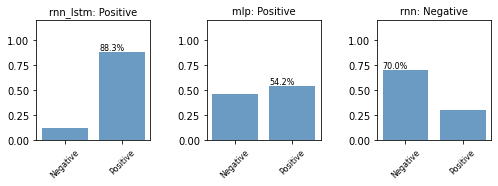

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.041012,0.9968,0.330073,0.8600,5120770,11.0
rnn_lstm,0.023722,0.9944,0.707861,0.7876,4321402,257.0
rnn,0.429040,0.8085,0.711746,0.5644,4080802,166.0


In [40]:
helper.model_summary(model, history=history)

### LSTM + Bidirectional + Stacked

In [41]:
def get_lstm_stacked(helper, name='rnn_lstm_stacked', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm_stacked(helper)
model.summary()

model_params.rnn_lstm_stacked.dropout=0.3
model_params.rnn_lstm_stacked.units=200
max_features=20000
model_params.rnn_lstm_stacked.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn_lstm_stacked/checkpoint
Model: "rnn_lstm_stacked"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 400)          641600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
________________

2021-01-04 09:04:02,917: INFO: start training


model_params.rnn_lstm_stacked.epochs=5
use ModelCheckpoint(filepath=./checkpoints/imdb/rnn_lstm_stacked/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
78/78 [==============================] - 126s 2s/step - loss: 0.6236 - accuracy: 0.6482 - val_loss: 0.6232 - val_accuracy: 0.7080
Epoch 2/5
78/78 [==============================] - 122s 2s/step - loss: 0.2454 - accuracy: 0.9022 - val_loss: 0.5814 - val_accuracy: 0.7328
Epoch 3/5
78/78 [==============================] - 122s 2s/step - loss: 0.1280 - accuracy: 0.9603 - val_loss: 0.6004 - val_accuracy: 0.7564
Epoch 4/5
78/78 [==============================] - 123s 2s/step - loss: 0.0453 - accuracy: 0.9864 - val_loss: 0.9175 - val_accuracy: 0.7612
Epoch 5/5
78/78 [==============================] - 123s 2s/step - loss: 0.0221 - accuracy: 0.9896 - val_loss: 1.0415 - val_accuracy: 0.7720


2021-01-04 09:14:33,292: INFO: finish training [elapsed time: 630.38 seconds]


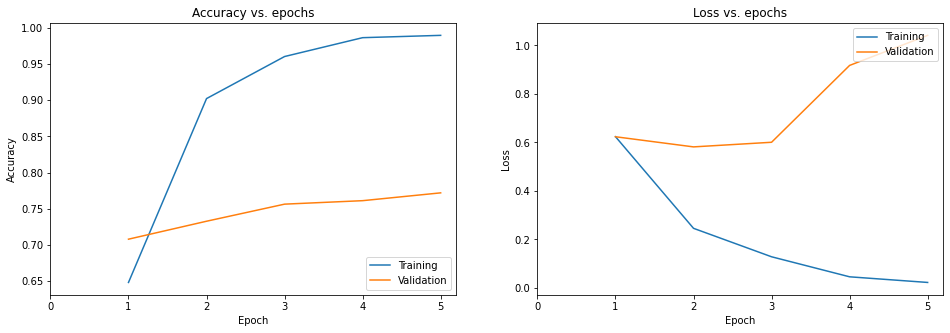

In [42]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
79/79 [==============================] - 25s 316ms/step - loss: 1.0415 - accuracy: 0.7720
Test loss:1.0415, Test Accuracy:77.20%
---------------------------------------- confusion matrix ----------------------------------------
79/79 [==============================] - 27s 340ms/step


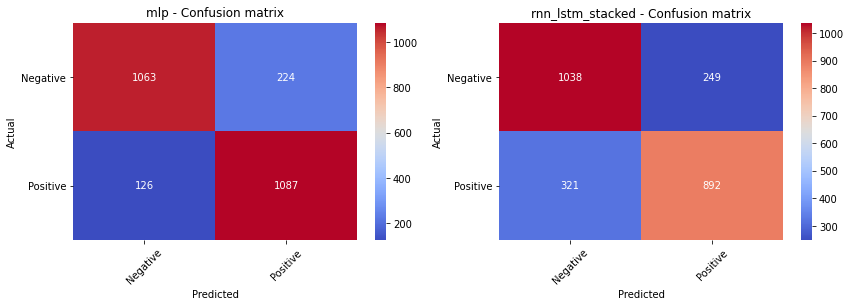

---------------------------------------- error analysis ----------------------------------------
79/79 [==============================] - 27s 336ms/step
........................................ Positive ........................................
Mike Judge's Idiocracy is an interesting film, and one that his fans will undoubtedly track down and see.<br /><br />Before I start the review, I would preface it by saying that if you get a chance to see it, definitely do, as it IS worth watching, and isn't the easiest film in the world to track down.<br /><br />Let's start with the premise - Luke Wilson is Private Joe Bauers, an Army librarian who is deemed to have absolutely no outstanding attributes or glaring flaws, making him totally average in every way. This, along with the fact that he has no living relatives, makes him a standout candidate for an experimental cryogenics procedure. Also frozen with Joe is a Prostitute named Rita who was pimped to the project by Upgrayedd, her abusive pim

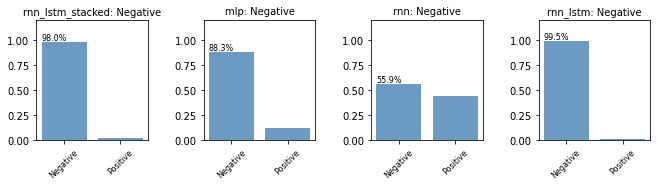

........................................ Negative ........................................
Speed which I believe is direct copy of the Hollywood movie Cellular (I haven't watched this one) gives an impression of a test match which is very exciting in first four days, but then gets in a very boring draw at the end. I have watched this movie today on 12th January 2008 on rented VCD. It's release date is 19th Oct 2007. But still fortunately for me I didn't know or heard much of this movie before except that it is a flop at box office. So in this situation when I watch the movie, I feel that this movie could have been a very good movie, but then the director again falls in the trap for Bollywood traditions and has wasted a very good chance.<br /><br />Off course as a Bhatt movie it must be copied from somewhere else. But now days it doesn't matter for me, if I haven't seen the original movie. I just found the main theme much similar to 'Nick of Time' and 'Badshah'. In the movie Sanjay Suri

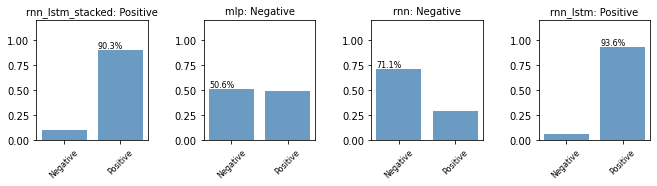

........................................ Negative ........................................
You have to see this. I could not stop laughing about the stupidities I saw in this movie even late after the event. There is maybe a million of individual mistakes and stupidities in this movie. The acting is bad. The story is so predictable and flat. The effects are like 50 years old. The supposed thriller is nowhere. You will not enjoy the movie, but you will laugh at it and enjoy laughing at it a long time after it. We had a great time AFTER the movie. Truly. Me and my friend spent entire 40mins long bus trip home chatting about this movie like we have seen next Oscar winner. Sadly we were talking about all those bad things we had just seen.


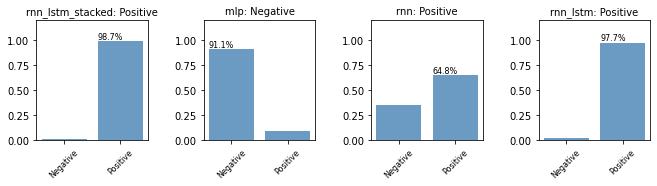

........................................ Positive ........................................
I watched this short moments ago on the Sundance Film Festival website, and I must say it is absolutely astounding. I expected it to be entertaining - like all of the Sundance shorts - but I wasn't prepared for such deep sadness and yet also a sense of passion and beauty. <br /><br />If you haven't yet seen any of this years entries to the festival, I suggest you go onto the site and watch these mini-masterpieces - I have seen them all, and can honestly say 'The Youth In Us' is the one that has touched my heart the most. I'm not the weakest audience member when it comes to romance in films, but my eyes flooded up so much I'm surprised I could still see the screen.<br /><br />I agree with 'addicted2you', it truly is a masterful piece of directorial work, and the cinematography will just take your breath away. <br /><br />I can't think of a better way to spend a spare 12 minutes.


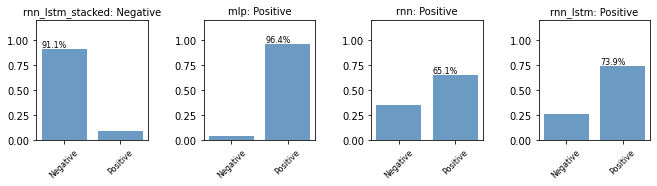

........................................ Negative ........................................
After seeing Forever Hollywood, it would be natural to want to see a John Waters film. At least, one get to say that they have joined the legions of cinema cognoscenti who have experienced the unique cinematic stylings of perhaps the best known non-mainstream director. It's worth the effort, and PF is a lot better than Eraserhead,and there is a certain campiness about his films which his followers find addicting.


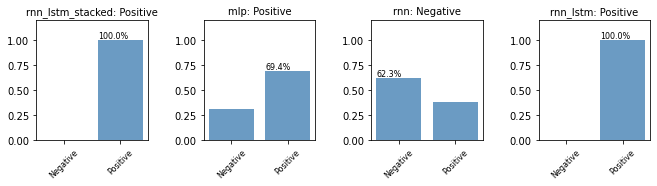

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.041012,0.9968,0.330073,0.8600,5120770,11.0
rnn_lstm,0.023722,0.9944,0.707861,0.7876,4321402,257.0
rnn_lstm_stacked,0.004432,0.9984,1.041531,0.7720,5123002,630.0
rnn,0.429040,0.8085,0.711746,0.5644,4080802,166.0


In [43]:
helper.model_summary(model, history=history)

### sepCNN

In [44]:
def get_sepcnn(helper,
                 blocks=2,
                 filters=64,
                 kernel_size=3,
                 embedding_dim=200,
                 dropout=None,
                 pool_size=3,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None, 
                 name='sepcnn'
                ):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
        
    input_shape = helper.data.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0],
                                   weights=[embedding_matrix],
                                   trainable=is_embedding_trainable))
    else:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(layers.Dropout(rate=dropout))
        model.add(layers.SeparableConv1D(filters=filters,
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.SeparableConv1D(filters=filters,     
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.MaxPooling1D(pool_size=pool_size))

    model.add(layers.SeparableConv1D(filters=filters * 2,
                                     kernel_size=kernel_size,
                                     activation='relu',
                                     bias_initializer='random_uniform',
                                     depthwise_initializer='random_uniform',
                                     padding='same'))
    model.add(layers.SeparableConv1D(filters=filters * 2,
                                     kernel_size=kernel_size,
                                     activation='relu',
                                     bias_initializer='random_uniform',
                                     depthwise_initializer='random_uniform',
                                     padding='same'))
    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(2))
    helper.compile(model)  
    return model

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_sepcnn(helper)
model.summary()

model_params.sepcnn.dropout=0.3
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/sepcnn/checkpoint
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 500, 64)           13464     
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 500, 64)           4352      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 64)           0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 166, 128)          8512      
_____________________

2021-01-04 09:16:31,558: INFO: start training


model_params.sepcnn.epochs=20
use ModelCheckpoint(filepath=./checkpoints/imdb/sepcnn/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/20
78/78 [==============================] - 3s 37ms/step - loss: 0.6935 - accuracy: 0.4968 - val_loss: 0.6931 - val_accuracy: 0.5148
Epoch 2/20
78/78 [==============================] - 3s 34ms/step - loss: 0.6937 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.5148
Epoch 3/20
78/78 [==============================] - 3s 34ms/step - loss: 0.6933 - accuracy: 0.4960 - val_loss: 0.6934 - val_accuracy: 0.4852
Epoch 4/20
78/78 [==============================] - 3s 33ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6930 - val_accuracy: 0.5148
Epoch 5/20
78/78 [==============================] - 3s 33ms/step - loss: 0.6944 - accuracy: 0.4792 - val_loss: 0.6935 - val_accuracy: 0.4852
Epoch 6/20
78/

2021-01-04 09:17:26,409: INFO: finish training [elapsed time: 54.85 seconds]


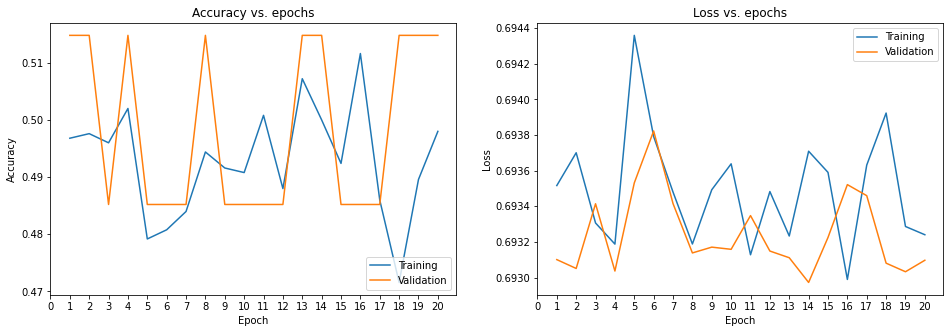

In [45]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
79/79 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5148
Test loss:0.6931, Test Accuracy:51.48%
---------------------------------------- confusion matrix ----------------------------------------
79/79 [==============================] - 0s 4ms/step


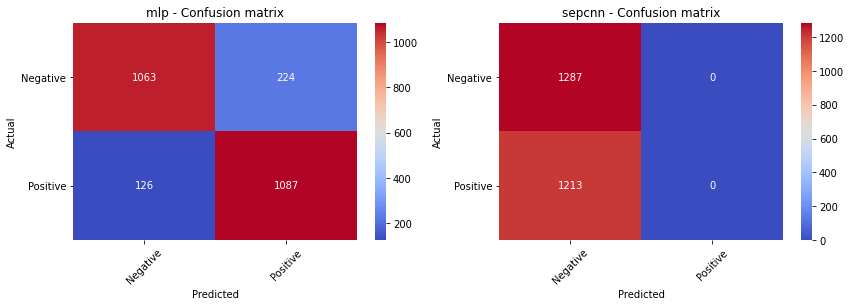

---------------------------------------- error analysis ----------------------------------------
79/79 [==============================] - 0s 4ms/step
........................................ Positive ........................................
This is the last episode of the Goldenboy OVA series. Kentaro finds himself working in an animation studio, which is rather interesting if you don't know anything about the way anime studios were run. Besides episode 3, this was probably the least risqué, but it had a nice girl interest, as well as a surprise reunion from others in the previous episodes. My only complaint about this episode is it seemed a little too short, but at the same time this may have only been because it was the only original script for the show that wasn't based on one of the manga chapters. but it ended well, leaving us with the nice feeling that Kentaro is permanently 25, studying on. Definitely watch the rest of the series all the way through, you can buy the whole series

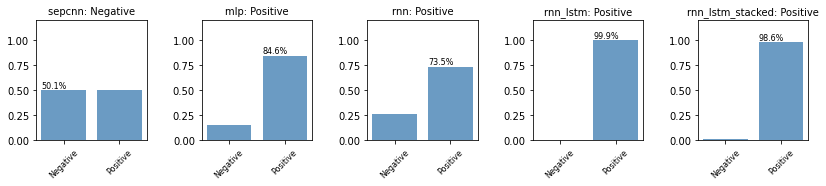

........................................ Positive ........................................
Dad (78) and I (46) both had a good time watching the flick today. For a guy primarily known for serious roles, De Niro is a heckuva comic actor. Of course, it helps to have his past film images to play against. Consider that one of those roles, 15 MINUTES, was a cop having to deal with the interference of the mass media, and you have an interesting set of compare/contrast performances.<br /><br />Murphy plays another of his Axel Foley sort of characters. Shatner plays a burlesque of himself, a parallel world self who was best known for TJ HOOKER and not STAR TREK.<br /><br />It's interesting to watch how the film comments on the contrasts between the reality of police work and its fictional counterparts in TV and film. Shatner lectures on the proper means of sliding across a car hood; De Niro points out holsters scratch the hood finish. Ironically, as the film progresses, De Niro's character beg

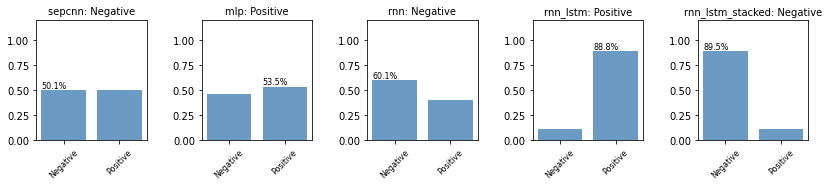

........................................ Positive ........................................
This is a simple episode ad so far after watching all of the Season 11 episodes (with the exception of the Imaginationland trilogy) this is the one that made laugh the most, definitely is my favourite so far of Season 11. So basically Cartman sees at a toy store a kid who has the Tourette's syndrome and a new idea comes to Cartman. You can imagine, now Cartman has Tourette's syndrome and is great since Kyle once he knows about this is like "he's faking". Cartman is certainly on fire, saying whatever he wants to the teachers, to the principal, to anybody. On the other hand we have Kyle who now is the intolerant one, basically for saying that Cartman was faking he was taken to meet children with Tourette's syndrome just to let him see that Tourette's syndrome is for real and is great since Kyle is like "well maybe someone is faking to have Tourette's for fun", in short Kyle could not explain that C

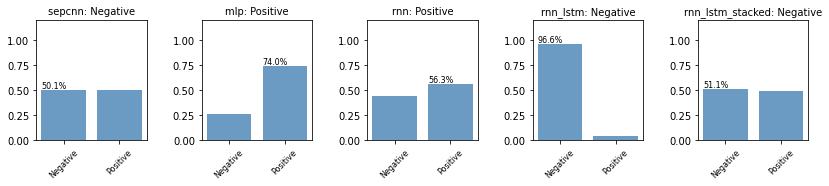

........................................ Positive ........................................
Words fail me whenever I want to describe my feelings about this movie (and the sequels)... Does it have flaws? Sure it does... Starting with the "Subspecies" themselves,which were not executed well enough for a special effect.So why do I glorify these movies??? For the herd of movie mass-consumers out there,who care more about quantity than quality,about cheap fun more than about depth, crap like "blade" (it doesn't even deserve a capital letter),"underworld","Dracula 2000","dracula 3000" and so on are good movies to munch popcorn to and drink a couple of cokes... What makes Subspecies a superior effort for anyone claiming to be a Vampire fanatic,on the other hand,is obvious: The Vampire Himself is Romanian,the story is set in Transylvania (the scenes filmed on location are more than convincing),and the atmosphere is not based on any "action-packed" chases or expensive orchestral music.Radu Hims

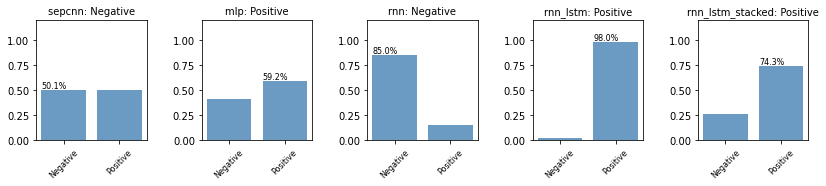

........................................ Positive ........................................
This mini-series is iconic of the Australian spirit. While there may be what are perhaps considered glaring inconsistencies, the film portrays a spirit that is unique to Australia, and one that should be cherished. If anything, this mini-series demonstrates the Aussie sense of humour. The ability to laugh at the supremely ridiculous. Our willingness to have a laugh in even the most dire of situations. While a large part of this series focuses on mateship and how humour can be used as a means of survival, it also has elements of drama that are evoke real emotions. The main actors who appear are absolutely sensational and very convincing in their different roles. Capturing the essence of their characters perfectly. This mini-series should be mandatory viewing for all Australians.


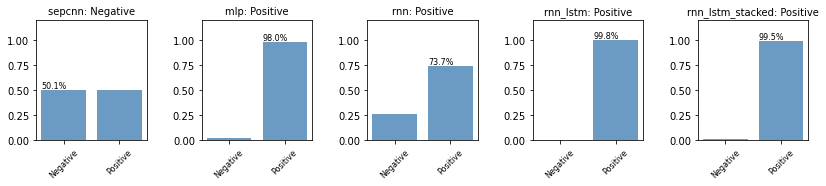

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.041012,0.9968,0.330073,0.8600,5120770,11.0
rnn_lstm,0.023722,0.9944,0.707861,0.7876,4321402,257.0
rnn_lstm_stacked,0.004432,0.9984,1.041531,0.7720,5123002,630.0
rnn,0.429040,0.8085,0.711746,0.5644,4080802,166.0
sepcnn,0.693147,0.5004,0.693101,0.5148,4043682,54.0


In [46]:
helper.model_summary(model, history=history)

## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)